In [16]:
import pickle
import numpy as np
from tqdm import tqdm

In [17]:
embs = pickle.load(open('Data/embeddings.pkl', 'rb'))

In [18]:
len(embs['descriptions'])

488897

In [19]:
len(embs['embeddings'])

488897

In [20]:
embs['embeddings'].shape

(488897, 768)

In [21]:
embs['embeddings'][0].shape

(768,)

In [22]:
embs['descriptions'][0]

'Symbol: ENG1 Type: protein Organism: Rhizomucor miehei Description: Cleaves internal linkages in 1,3-beta-glucan. Tris binds the active site and may act as an inhibitor. Belongs to the glycosyl hydrolase 81 family.'

In [23]:
embs['descriptions'][10]

'Symbol: DAHP1 Type: protein Organism: Petunia hybrida Description: Involved in the production of volatile organic compounds (VOCs), including floral volatile benzenoids and phenylpropanoids (FVBP), in flowers of fragrant cultivars (e.g. cv. Mitchell and cv. V26), scent attracting pollinators (e.g. the night-active hawkmoth pollinator Manduca sexta) . Catalyzes an aldol-like condensation reaction between phosphoenolpyruvate (PEP) and D-erythrose 4-phosphate (E4P) to generate 3-deoxy-D-arabino-heptulosonate 7-phosphate (DAH7P) and inorganic phosphate (By similarity). Binds 1 divalent metal cation per subunit that could be manganese. Metabolic intermediate biosynthesis; chorismate biosynthesis; chorismate from D-erythrose 4-phosphate and phosphoenolpyruvate: step 1/7. Homodimer. Mostly expressed in flowers, especially in petal limbs and tubes, and, to a lower extent, in roots, stems, stigmas, anthers, leaves and sepals. During floral development, accumulates to highest levels during open

In [24]:
no_symbol = 0
no_type = 0
no_organism = 0
no_description = 0
for i, des in enumerate(embs['descriptions']):
    if 'Symbol' not in des:
        no_symbol += 1
    if 'Organism' not in des:
        no_organism += 1
    if 'Description' not in des:
        no_description += 1
    if 'Type' not in des:
        no_type += 1
print('No symbol: ', no_symbol)
print('No organism: ', no_organism)
print('No description: ', no_description)
print('No type: ', no_type)

No symbol:  0
No organism:  0
No description:  0
No type:  0


In [25]:
from collections import defaultdict
import pandas as pd


res = defaultdict(dict)
organisms = set()
entities = set()
types = set()
meta = []
for i, des in enumerate(embs['descriptions']):
    symbol = des.split('Type')[0].split(':')[-1].strip()
    type = des.split('Organism')[0].split(':')[-1].strip()
    organism = des.split('Description')[0].split(':')[-1].strip()
    description = des.split('Description')[-1].split(':')[-1].strip()
    
    res[i]['Symbol'] = symbol
    res[i]['Type'] = type
    res[i]['Organism'] = organism
    res[i]['Description'] = description
    res[i]['Embedding'] = embs['embeddings'][i]

    organisms.add(organism)
    entities.add(organism + '_' + symbol)
    types.add(type)
    meta.append([symbol, type, organism, description])

with open('Data/TokLen50/embeddings_tok_len_50.pickle', 'wb') as f:
    pickle.dump(res, f)

meta = pd.DataFrame(meta, columns=['Symbol', 'Type', 'Organism', 'Description'])
meta

,Symbol,Type,Organism,Description
0,ENG1,protein,Rhizomucor miehei,"Cleaves internal linkages in 1,3-beta-glucan. ..."
1,cbh2,protein,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,1 ration with a single GlcNAc. Asn-313 was pri...
2,Orco,protein,Ooceraea biroi,Odorant coreceptor which complexes with conven...
3,Bli,protein,Onchocerca volvulus,Serine endoprotease which cleaves substrates a...
4,CCR1,protein,Petunia hybrida,Involved in the latter stages of lignin biosyn...
...,...,...,...,...
488892,RPS8,protein,Griffithsia japonica,Belongs to the eukaryotic ribosomal protein eS...
488893,ninE,protein,Escherichia phage 933W,Belongs to the ninE family.
488894,AP,protein,Fragaria ananassa,"Interacts with FRAA1E, FRAA2 and FRAA3."
488895,GUCA1ANB,protein,Homo sapiens,Product of a dubious gene prediction.


In [27]:
organism_count = meta.value_counts('Organism')
organisms_to_keep = organism_count[organism_count > 1000].index.to_list()
print(len(organism_count), len(organisms_to_keep))
print(meta.shape)
print(meta[[o in organisms_to_keep for o in meta.Organism]].shape)

meta_to_keep = meta[[o in organisms_to_keep for o in meta.Organism]]

from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-sci-base")

descs = meta_to_keep.Description.to_list()
tok_lens = []
for desc in tqdm(descs):
    tok_lens.append(len(tokenizer.tokenize(desc, padding=True, truncation=True, return_tensors="pt")))
meta_to_keep['tok_len'] = tok_lens

print(meta_to_keep)
meta_to_keep = meta_to_keep[meta_to_keep.tok_len > 50]

embs_to_keep = meta_to_keep.index.to_list()
print(len(embs_to_keep))

res = pickle.load(open('Data/embeddings_.pickle', 'rb'))

res_to_keep = {
    k: v for k, v in tqdm(res.items()) if k in embs_to_keep
}

pickle.dump(res_to_keep, open('Data/TokLen50/embeddings_1000.pickle', 'wb'))


11145 30
(488897, 4)
(119830, 4)


100%|██████████| 119830/119830 [00:55<00:00, 2143.52it/s]
C:\Users\wuqi0\AppData\Local\Temp\ipykernel_35308\50596245.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_to_keep['tok_len'] = tok_lens


             Symbol     Type  \
6            pezo-1  protein   
28            Auts2  protein   
29           CYP2D7  protein   
31      Iqcj-Schip1  protein   
32             msl3  protein   
...             ...      ...   
488870    LINC00312  protein   
488878         yjgW  protein   
488885         yubL  protein   
488895     GUCA1ANB  protein   
488896       SYT15B  protein   

                                                 Organism  \
6                                  Caenorhabditis elegans   
28                                           Mus musculus   
29                                           Homo sapiens   
31                                           Mus musculus   
32      Mycobacterium tuberculosis (strain ATCC 25618 ...   
...                                                   ...   
488870                                       Homo sapiens   
488878                      Escherichia coli (strain K12)   
488885                                                 H7   
48889

100%|██████████| 488897/488897 [03:17<00:00, 2469.98it/s]


Filtered organisms with less than 1000 proteins

In [28]:
meta_to_keep

,Symbol,Type,Organism,Description,tok_len
6,pezo-1,protein,Caenorhabditis elegans,Pore-forming subunit of a mechanosensitive non...,344
28,Auts2,protein,Mus musculus,Component of a Polycomb group (PcG) multiprote...,512
29,CYP2D7,protein,Homo sapiens,May be responsible for the metabolism of many ...,101
31,Iqcj-Schip1,protein,Mus musculus,May play a role in action potential conduction...,292
32,msl3,protein,Mycobacterium tuberculosis (strain ATCC 25618 ...,Polyketide synthase involved in the biosynthes...,262
...,...,...,...,...,...
488380,cbpM,protein,H1 (strain CFT073 / ATCC 700928 / UPEC),Interacts with CbpA and inhibits both the DnaJ...,59
488483,syd,protein,H7,Interacts with the SecY protein in vivo. May b...,72
488520,cbpM,protein,Salmonella typhi,Interacts with CbpA and inhibits both the DnaJ...,59
488732,CNRIP1,protein,Macaca fascicularis,Suppresses cannabinoid receptor CNR1-mediated ...,56


In [29]:
res = pickle.load(open('Data/TokLen50/embeddings_1000.pickle', 'rb'))

In [30]:
embs = np.array([v['Embedding'] for k, v in res.items()])
embs.shape

(80536, 768)

In [31]:
import umap
reducer = umap.UMAP(
    n_neighbors=15,
    metric='euclidean', # 'cosine', 'euclidean'
    # densmap=True
)
umap_embeddings = reducer.fit_transform(embs)

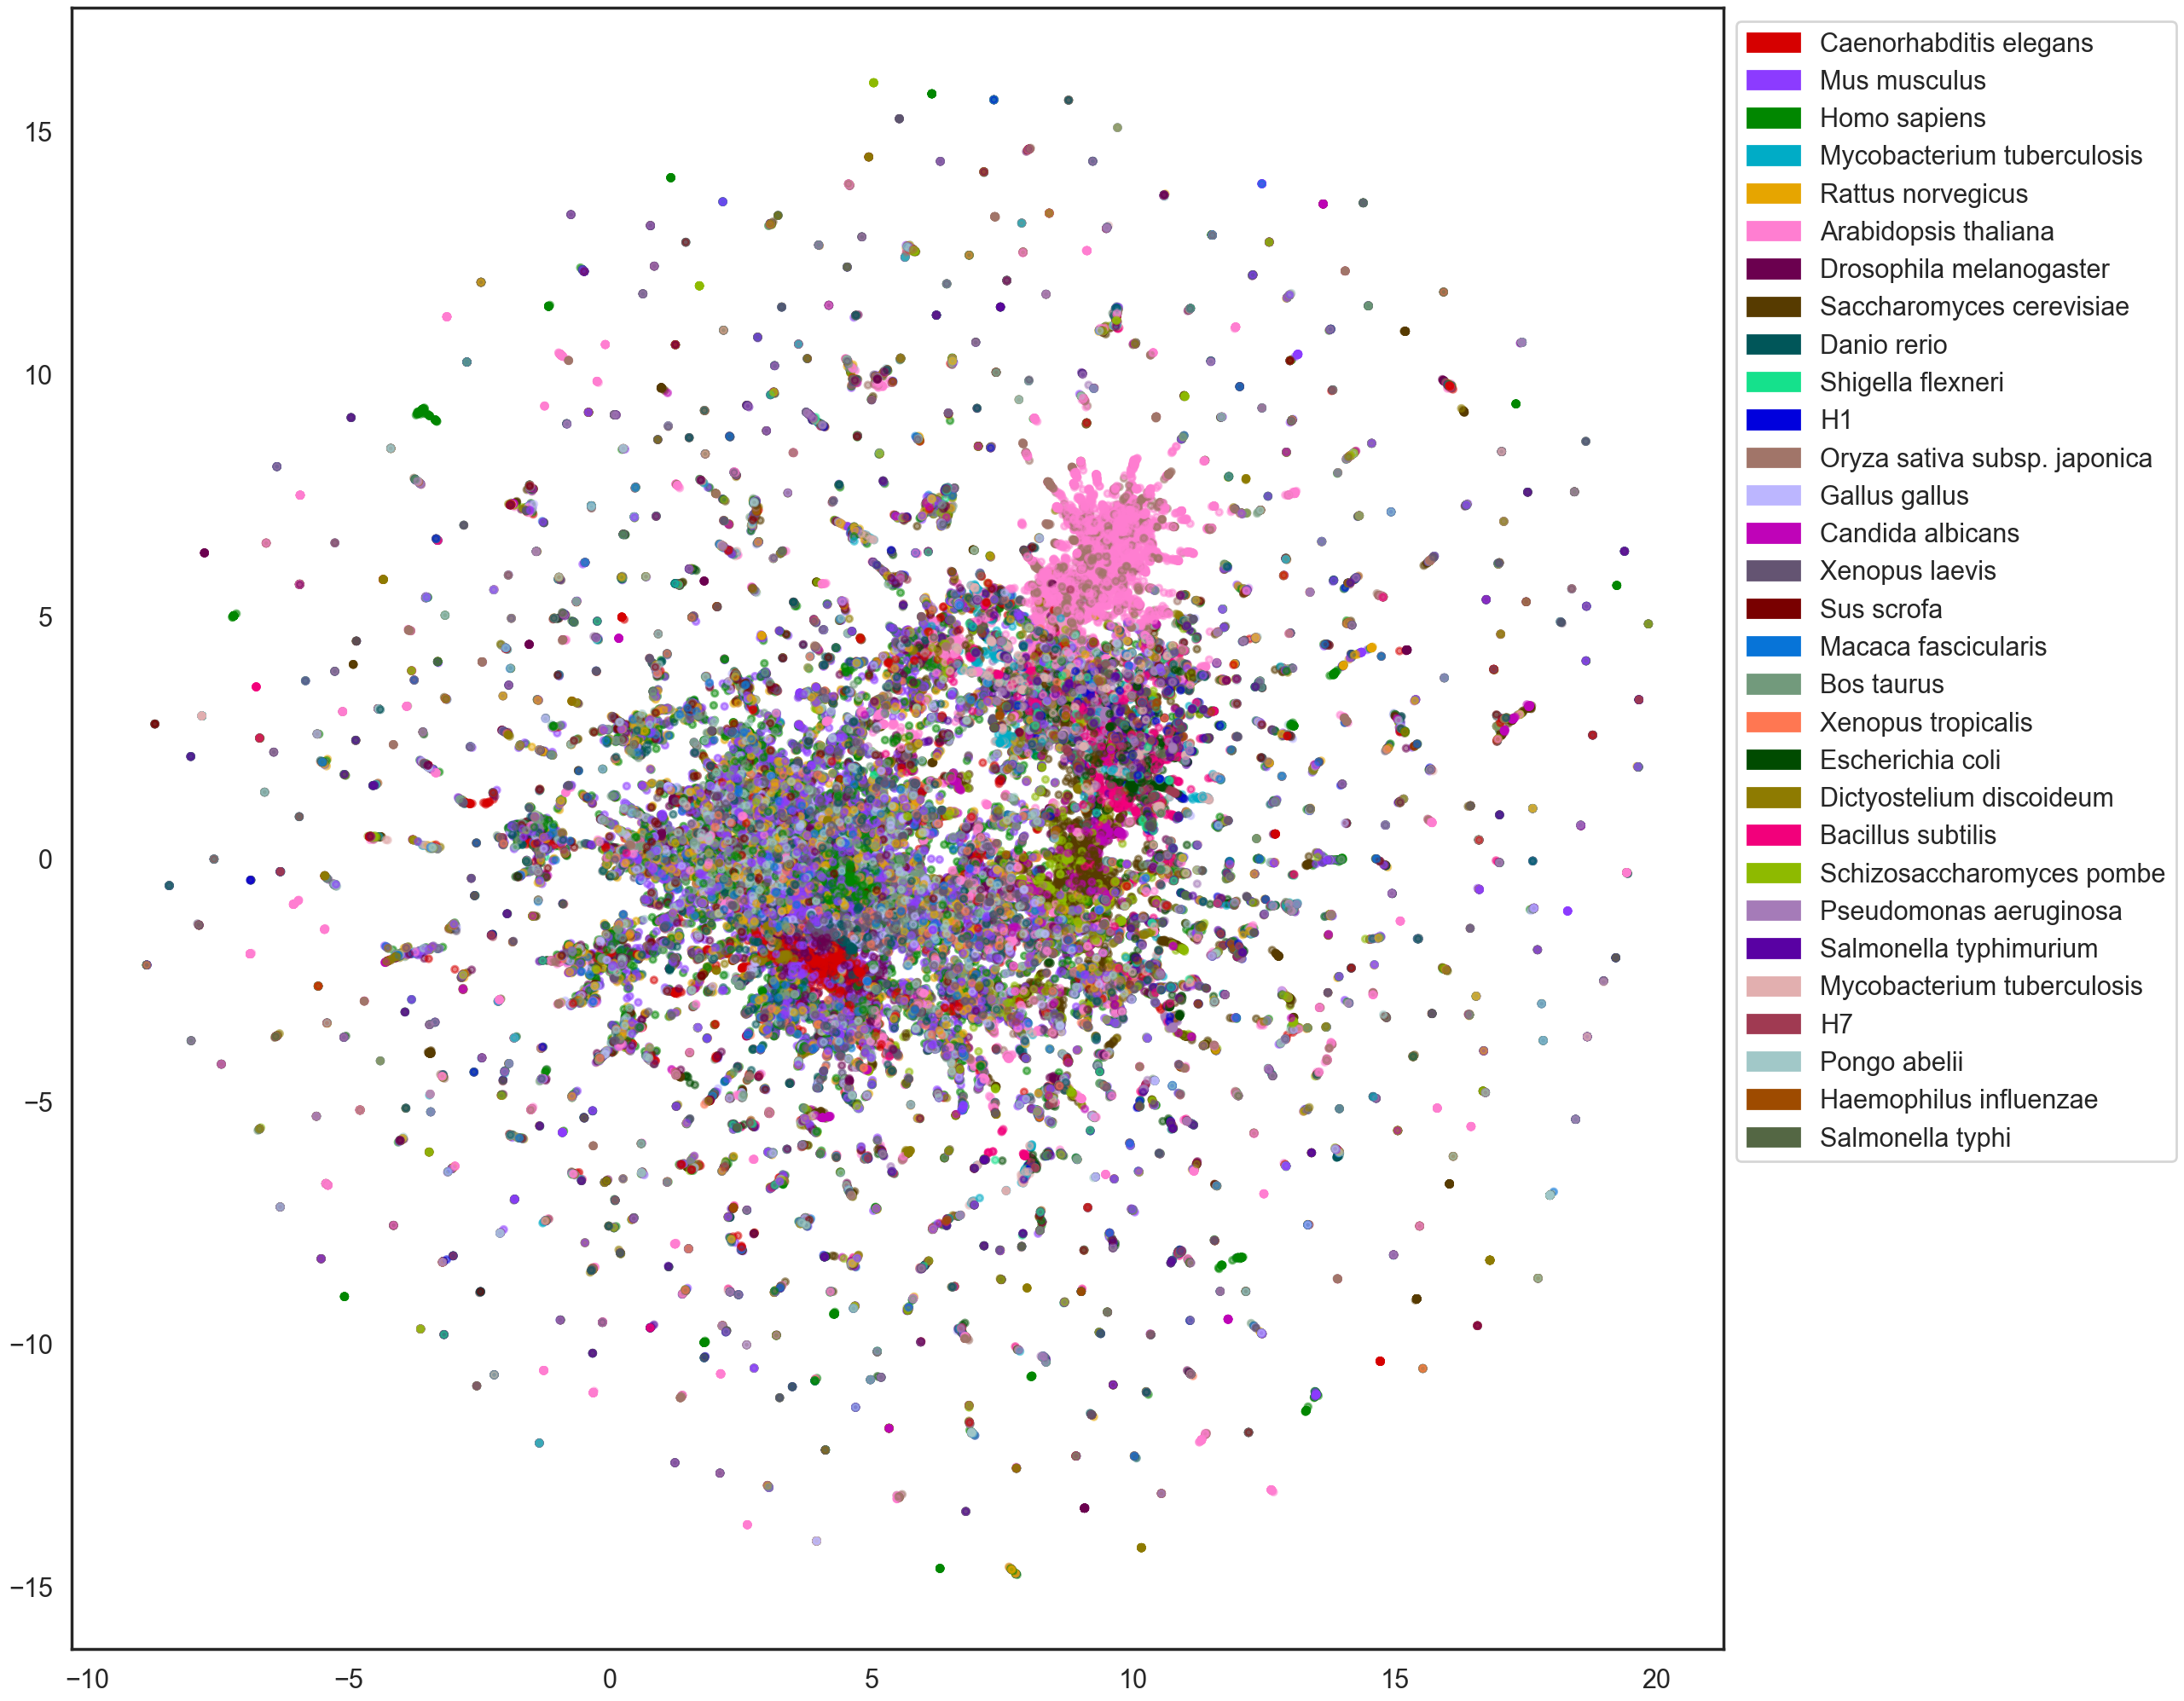

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import re

sns.set(style='white', context='poster', rc={'figure.figsize':(25,25)})
palette = sns.color_palette(cc.glasbey_dark, n_colors=30) # glasbey_bw_minc_20
organism_mapper = {o:i for i,o in enumerate(meta_to_keep.Organism.unique())}
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=[palette[x] for x in meta_to_keep.Organism.map(organism_mapper)],
    s=30,
    alpha=0.5,
)
import matplotlib.patches as mpatches
patches = [
    mpatches.Patch(color=palette[i], label=re.sub("[\(\[].*?[\)\]]", "", o).strip()) for i, o in enumerate(meta_to_keep.Organism.unique())
]
plt.legend(handles=patches, bbox_to_anchor=(1, 1))
plt.show()

In [33]:
umap_embeddings.shape

(80536, 2)

In [34]:
umap_emb = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
organism_mapper = {o:i for i,o in enumerate(meta_to_keep.Organism.unique())}
umap_emb_labels = pd.DataFrame(meta_to_keep.Organism)

In [36]:
umap_emb.to_csv('Outputs/tok_len_50/umap_embeddings_1.tsv', index=False, header=False, sep='\t')
meta_to_keep.to_csv('Outputs/tok_len_50/umap_embeddings_labels_1.tsv', index=False, header=True, sep='\t')

In [37]:
umap_emb.shape

(80536, 2)

In [38]:
tensorflow_projector_config = {
  "embeddings": [
    {
      "tensorName": "vis",
      "tensorShape": [80536, 2],
      "tensorPath": "https://raw.githubusercontent.com/qwu01/NLP_Projects/master/Outputs/tok_len_50/umap_embeddings_1.tsv",
      "metadataPath": "https://raw.githubusercontent.com/qwu01/NLP_Projects/master/Outputs/tok_len_50/umap_embeddings_labels_1.tsv"
    }
  ]
}
import json
json.dump(tensorflow_projector_config, open('Outputs/tok_len_50/tensorflow_projector_config_1.json', 'w'))

In [39]:
# import umap
# reducer = umap.UMAP(
#     n_neighbors=15,
#     metric='cosine', # 'cosine', 'euclidean'
#     # densmap=True
# )
# umap_embeddings = reducer.fit_transform(embs)

# umap_emb = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
# organism_mapper = {o:i for i,o in enumerate(meta_to_keep.Organism.unique())}
# umap_emb_labels = meta_to_keep
# umap_emb.to_csv('Outputs/umap_embeddings_1_cos.tsv', index=False, header=False, sep='\t')
# umap_emb_labels.to_csv('Outputs/umap_embeddings_labels_1_cos.tsv', index=False, header=True, sep='\t')